### 3.4. Решение линейного стока. Запуск и остановка скважины. Суперпозиция

Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

Версия 0.1 от 17.10.2023

Хабибуллин Ринат 2023 г.

---

Содержание

1. [Решение линейного стока](#341)
2. [Расчет кривой восстановления давления](#342)
3. [Построение графиков распределения давления в пласте при восстановлении давления](#343)
4. [Задания для самостоятельной работы](#344)

In [1]:
# импортируем библиотеки для расчетов

# numpy используем для работы с массивами и подготовки данных для построения графиков. 
# Также в некоторых функциях используем возможности векторных расчетов numpy
import numpy as np

# matplotlib используем для построения графиков
import matplotlib.pyplot as plt

# scipy.special используем как альтернативный вариант расчета специальных функций
import scipy.special as sc

# 1. Решение линейного стока <a class="anchor" id="341"></a>

Решение линейного стока (с бесконечно малым радиусом скважины) можно представить в виде.

$$ 
p_D(r_D,t_D) = - \frac{1}{2} Ei \left(- \dfrac{ r_D^2}{4t_d} \right)
\tag{1}
$$

In [2]:
# Решение линейного стока уравнения фильтрации
def pd_ei(td, rd):
    """
    Решение линейного стока уравнения фильтрации
    rd - безразмерное расстояние
    td - безразмерное время
    """
    return -1/2*sc.expi(-rd**2 / 4 / td)


$$ r_D = \frac{r}{r_w} \tag{2} $$
$$ t_D = \frac{0.00036 kt}{\phi \mu c_t r_w^2}  \tag{3}$$
$$ p_D = \frac{kh}{ 18.41 q_s B \mu} \left( p_i - p \right)  \tag{4} $$

Здесь использование единицы измерения СИ.
* $r_w$ - радиус скважины, м
* $r$ - расстояние от центра скважины до точки в пласте, м
* $q_s$ - дебит скважины на поверхности, приведенный к нормальным условиям м3/сут
* $\phi$ - пористость, доли единиц
* $\mu$ - вязкость нефти в пласте, сП
* $B$ - объемный коэффициент нефти, м3/м3
* $p_i$ - начальное давление в пласте, атм
* $p$ - давление на расстоянии $r$, атм
* $c_t$ - общая сжимаемость системы в пласте, 1/атм

In [3]:
# определим функции для перевода размерных переменных в безразмерные и обратно
# пригодится потом для построения графиков и ведения расчетов

# при наименовании функций придерживаемся следующих соглашений
# сначала идет название того, что считаем
# в конце указывается размерность результата, если это уместно

def r_from_rd_m(rd, rw_m=0.1):
    """
    перевод безразмерного расстояния в размерное
    rd -  безразмерное расстояние
    rw_m -  радиус скважины, м
    """
    return rd*rw_m

def rd_from_r(r_m, rw_m=0.1):
    """
    перевод размерного расстояния в безразмерное
    r_m - размерное расстояние, м
    rw_m - радиус скважины, м
    """
    return r_m/rw_m

def t_from_td_hr(td, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод безразмерного времени в размерное, результат в часах
    td - безразмерное время
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return td * phi * mu_cP * ct_1atm * rw_m * rw_m / k_mD / 0.00036

def td_from_t(t_hr, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод размерного времени в безразмерное
    t_hr - размерное время, час
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return  0.00036 * t_hr * k_mD / (phi * mu_cP * ct_1atm * rw_m * rw_m) 

def p_from_pd_atma(pd, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод безразмерного давления в размерное, результат в абсолютных атмосферах
    pd - безразмерное давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return pi_atma - pd * 18.41 * q_sm3day * b_m3m3 * mu_cP / k_mD / h_m 

def pd_from_p(p_atma, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод размерного давления в безразмерное
    p_atma - давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return (pi_atma - p_atma) / (18.41 * q_sm3day * b_m3m3 * mu_cP) * k_mD * h_m 

# 2. Расчет кривой восстановления давления <a class="anchor" id="342"></a>

Один из самых простых примеров применения суперпозиции. Предполагаем, что добывающая скважина в однородном изотропном пласте запускается в момент времени `t=0` и работает `t_p_hr` часов, после чего останавливается. После остановки скважины забойное давление растет - и мы получим кривую восстановления давления.

Пусть решение задачи запуска скважины (падения давления) будет $P_D(t_D, r_D)$. Тогда решение для изменения давления при запуске и последующей остановки скважины можно представить в виде 
$$P_{bu.D}(t_D, t_{prod.D}, r_D) = P_D(t_D) - P_D(t_D-t_{prod.D}, r_D) \cdot \mathcal{H}(t_D-t_{prod.D})  \tag{5}$$

где
* $t_D$ - безразмерное время после запуска скважины,
* $t_{prod.D}$ - безразмерное время работы скважины после запуска
* $\mathcal{H}$ - ступенчатая [функция Хевисайда](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0) (в некоторых книгах обозначается как $\theta$)
* $P_D(t_D, r_D)$ - безразмерное давление - решение задачи запуска скважины (падения давления)
* $P_{bu.D}(t_D, t_{prod.D}, r_D)$ - безразмерное давление- решение задачи запуска скважины и последующей остановки скважины

Для проведения векторных расчетов в python удобно выражение с использованием функции Хевисайда

$$ \mathcal{H} = \begin{cases}0 & x < 0\\1 & x = 0\\1 & x > 0\end{cases}$$

Применение функции Хевисайда позволяет избежать в расчетных функциях применение условных операторов в явном виде для отдельных элементов входных массивов. Это потенциально ускоряет расчет. 


In [4]:
def pd_build_up(td, td_p, rd):
    """
    расчет давления для запуска и последующей остановки скважины
    td - время после запуска
    td_p - время безразмерное - которое скважина работала до остановки
    rd - расстояния от скважины
    """
    
    # применение функции Хевисайда здесь делает расчет корректным
    # для входных векторов td
    return pd_ei(td, rd) - np.heaviside(td-td_p,1) * pd_ei(td-td_p, rd)

время работы скважины 24.00 часа, что соответсвует безразмерному времени 4320000.00


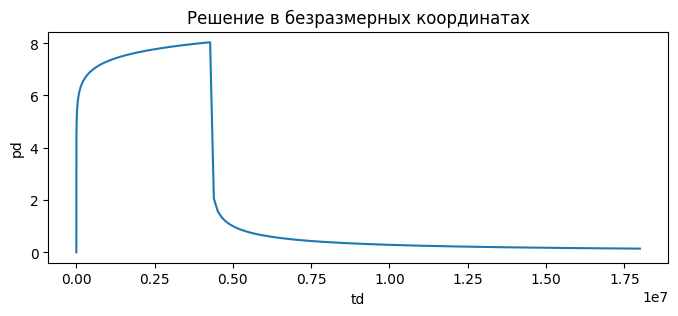

In [5]:
t_arr = np.logspace(-10, 2, 1000)
t_prod_hr = 24
k = 10   # проницаемость
q = 30   # дебит

# переведем размерный массив времени в безразмерные величины
# некоторые параметры можно было бы пропустить и оставить значения по умолчанию
# но для полноты приведем их в явном виде

td_arr = td_from_t(t_arr, k_mD=k, phi=0.2, mu_cP=1, ct_1atm=1e-05, rw_m=0.1)
td_prod = td_from_t(t_prod_hr, k_mD=k, phi=0.2, mu_cP=1, ct_1atm=1e-05, rw_m=0.1)

print('время работы скважины {:.2f} часа, что соответсвует безразмерному времени {:.2f}'.format(t_prod_hr, td_prod))

# для заданного массива безразмерных времен рассчитаем безразмерные давления
pd_arr = pd_build_up(td_arr, td_prod, rd=1)

# построение графика
plt.rcParams["figure.figsize"] = (8,3)

plt.plot(td_arr, pd_arr)

plt.xlabel('td')
plt.ylabel('pd')
plt.title('Решение в безразмерных координатах')
plt.show()

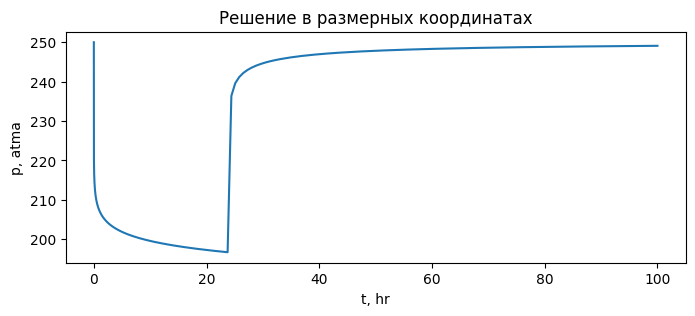

In [6]:
# переведем безразмерные координаты в размерные
p_arr = p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250)

plt.rcParams["figure.figsize"] = (8,3)
plt.plot(t_arr, p_arr)
plt.xlabel('t, hr')
plt.ylabel('p, atma')
plt.title('Решение в размерных координатах')
plt.show()

# 3. Построение графиков распределения давления в пласте при восстановлении давления <a class="anchor" id="343"></a>

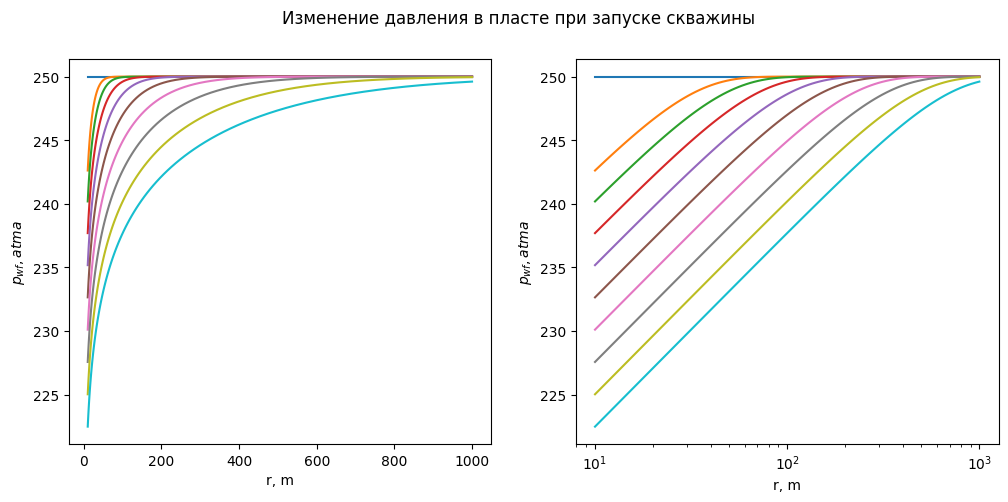

In [7]:
r_arr = np.logspace(1, 3, 100)
t_arr = np.logspace(-1, 2, 10)
t_arr[0] = 0.001
t_prod = 100

tv, rv = np.meshgrid(td_from_t(t_arr),rd_from_r(r_arr))
pd_arr =pd_ei(tv, rd=rv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при запуске скважины')
ax1.plot(r_arr, p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')

ax2.plot(r_arr,p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()

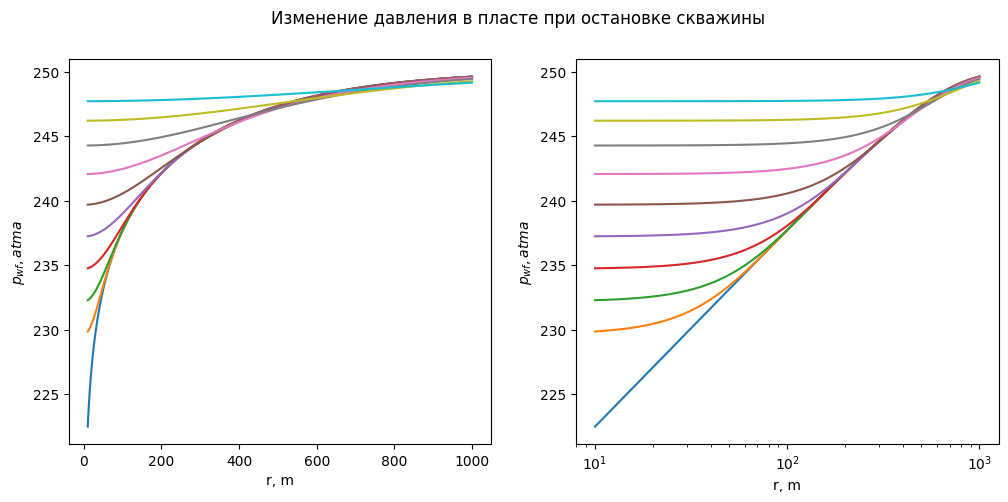

In [8]:
pd_arr_bu =pd_ei(tv + td_from_t(t_prod), rd=rv) - pd_ei(tv, rd=rv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при остановке скважины')
ax1.plot(r_arr, p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')

ax2.plot(r_arr,p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()

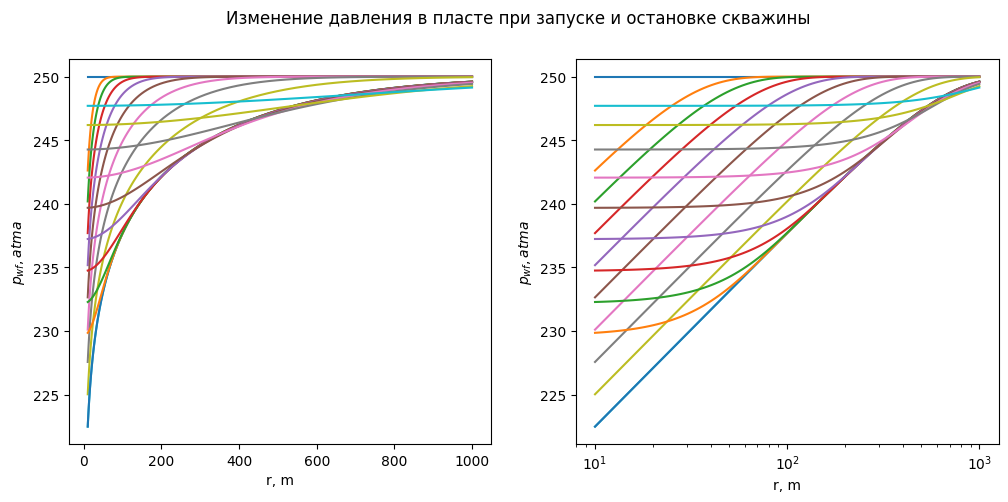

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при запуске и остановке скважины')
ax1.plot(r_arr,p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.plot(r_arr,p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')
ax2.plot(r_arr,p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax2.plot(r_arr,p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))

ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()

# 4 Задания для самостоятельной работы <a class="anchor" id="344"></a>

Для совершенствования навыков работы с python выполните следующие задания:

1. Постройте графики изменения давления в области дренирования при произвольном изменении дебитов